In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import linalg
from scipy.optimize import minimize
from matplotlib import patches

## Q1. Re-visit pset 1, and get covariance error ellipse

In [128]:
file = pd.read_csv(r"data.txt", delimiter='\s+', header = None)
x = file.iloc[:,0]
y = file.iloc[:,1]
sigma_y = file.iloc[:,2]
sigma_x = file.iloc[:,3]
rho_xy = file.iloc[:,4]

#### Function to get covariance matrix

In [129]:
#we need to construct the following matrices: X, Y, C^-1, and solve for Theta

def get_unc_matrix(x,y,sigma_y):

    dim = len(x)
    X = np.ones((dim,2))
    X[:,0] = x
    Y = y
    
    C_inv = np.zeros((dim, dim))
    var_inv = [1/s**2 for s in sigma_y]
    np.fill_diagonal(C_inv, var_inv)

    info_inv = np.matmul(np.matmul(np.transpose(X), C_inv), X) #information inverse matrix
    info = np.linalg.solve(info_inv, np.identity(2)) #solve(a,b) solves equation for x: Ax = b

    proj = np.matmul(np.matmul(np.transpose(X), C_inv), Y) #projection matrix

    Theta = np.matmul(info, proj)

    unc_matrix = np.linalg.solve(np.matmul(np.matmul(np.transpose(X), C_inv), X), np.identity(2))
    
    return unc_matrix

#### Function to get ellipse parameters

In [133]:
def get_ellipse(x,y,sigma_y):
    
    unc_matrix = get_unc_matrix(x,y,sigma_y)
    print('Covariance matrix = {}'.format(unc_matrix), '\n')
    eigval, eigvec = linalg.eig(unc_matrix)

    #semi major and semi minor radii are square roots of eigenvalues.
    r1 = np.sqrt(np.real(eigval[0]))
    r2 = np.sqrt(np.real(eigval[1]))

    #the orientation of the ellipse is the angle (lambda1-a/b), where covar matrix is [a b; b c]
    a = unc_matrix[0][0]
    b = unc_matrix[1][0]
    c = unc_matrix[1][1]
    alpha = np.arctan2(np.real(eigval[0])-a, b)

    trange = np.linspace(0,2*np.pi,100)
    x_ellipse = [r1*np.cos(alpha)*np.cos(t) - r2*np.sin(alpha)*np.sin(t) for t in trange]
    y_ellipse = [r1*np.sin(alpha)*np.cos(t) + r2*np.cos(alpha)*np.sin(t) for t in trange]
    
    return x_ellipse, y_ellipse

#### Plot the ellipses from q1, q2 from pset01

Covariance matrix = [[ 1.16166311e-02 -1.88954491e+00]
 [-1.88954491e+00  3.32922601e+02]] 

Covariance matrix = [[ 5.99181008e-03 -1.05427206e+00]
 [-1.05427206e+00  2.07188189e+02]] 



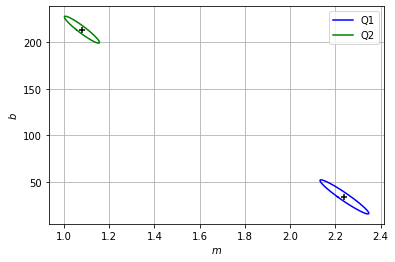

In [146]:
#plot datapoint along with its uncertainty
fig, ax = plt.subplots()
ax.set_ylabel(r'$b$')
ax.set_xlabel(r'$m$')

#q1.
m, intercept = 2.24, 34.05 #MLE estimates
x_ellipse, y_ellipse = get_ellipse(x[4:],y[4:],sigma_y[4:])
x_ellipse = [x_ellipse[i] + m for i in range(len(x_ellipse))]
y_ellipse = [y_ellipse[i] + intercept for i in range(len(y_ellipse))]
_= ax.plot(x_ellipse, y_ellipse, 'b-', label = 'Q1')
#_= ax.plot([m+np.sqrt(a), m-np.sqrt(a)], [intercept-np.sqrt(c), intercept+np.sqrt(c)], 'b-', alpha = 0.4)
_= ax.scatter(m, intercept, s = 36, marker = '+', c='k')

#q2
m, intercept = 1.08, 213.27 #MLE estimates
x_ellipse, y_ellipse = get_ellipse(x,y,sigma_y)
x_ellipse = [x_ellipse[i] + m for i in range(len(x_ellipse))]
y_ellipse = [y_ellipse[i] + intercept for i in range(len(y_ellipse))]
_= ax.plot(x_ellipse, y_ellipse, 'g-', label = 'Q2')
#_= ax.plot([m+np.sqrt(a), m-np.sqrt(a)], [intercept-np.sqrt(c), intercept+np.sqrt(c)], 'b-', alpha = 0.4)
_= ax.scatter(m, intercept, s = 36, marker = '+', c='k')

ax.grid()
ax.legend()

#### Recall that Q2 included the outliers that make the linear fit a poor choice. Despite that, it is suggested by the above plot that the uncertainties in $m,b$ are similar (if not smaller). The sizes of uncertainties are in no way a fair indicator as to whether a particular fit is a good choice, or not. 

## Q2. Find standard uncertainty in T

#### We can just adopt the laziest frequentist method of plotting Likelihood v parameter, finding the max likelihood value, do a cut-off at 68$^{\mathrm{th}}$ percentile, and obtain the width of that peak at that percentile

#### literally the function used in pset02 to obtain profiled likelihood:

In [159]:
df = pd.read_pickle("./data.pkl") 
X_data = df[:,0]
Y_data_err = df[:,1]
Y_data = df[:,-1]

T0 = 100
T_list = np.append(np.linspace(1,80,80), np.linspace(120,400,281)) #append two arrays that exclude the
        #T=100 region.

likelihood = []
for T1 in T_list:
    #calc. chi_sq
    def chi_sq(params):
        A1, A2, B = 2.06095, 2.31405, 0.03377
        A3, A4 = params[0], params[1]
        y_fit = [A1*np.cos(2*np.pi*X_data[i]/T0) + A2*np.sin(2*np.pi*X_data[i]/T0) + B + \
                 A3*np.cos(2*np.pi*X_data[i]/T1) + A4*np.sin(2*np.pi*X_data[i]/T1) \
                 for i in range(len(X_data))]
        func_list = [(Y_data[i]-y_fit[i])**2/Y_data_err[i]**2 for i in range(len(X_data))]
        ans = np.sum(func_list)
        return ans
    LL_model = minimize(chi_sq, np.array([1,1]), method = 'L-BFGS-B',tol = 1e-6) #minimize chi-square
    A3, A4 = LL_model.x[0], LL_model.x[1]
    likelihood.append(-1/2*chi_sq([A3, A4]))

index_max = max(range(len(likelihood)), key=likelihood.__getitem__)

#deal with uncertainties
covar = LL_model.hess_inv
covar = covar * np.identity(covar.shape[1]) 
A3_err = np.sqrt(covar[0][0])*1e-3
A4_err = np.sqrt(covar[1][1])*1e-3    

#### Make similar plot as in pset02. But now, we will also have a cut-off at 68th percentile, and will extract a likelihood from that.

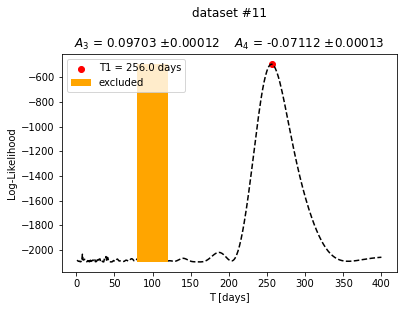

In [160]:
fig, ax = plt.subplots()
ax.plot(T_list, likelihood,'k--')
ax.scatter([T_list[index_max]],[likelihood[index_max]],marker = 'o', c='red',\
           label = r'T1 = {} days'.format(round(T_list[index_max],2)))
ax.set_xlabel('T [days]')
ax.set_ylabel('Log-Likelihood')
str1 = 'dataset #{}\n'.format(11) + '\n'
str2 = r'$A_3$ = {} $\pm$'.format(round(A3,5)) + '{}'.format(round(A3_err,5)) + '\t'
str3 = r'$A_4$ = {} $\pm$'.format(round(A4,5)) + '{}'.format(round(A4_err,5))
ax.set_title(str1+str2+str3)


rectangle = patches.Rectangle((80, min(likelihood)), 40, abs(max(likelihood) - min(likelihood)), edgecolor='None',\
                              facecolor="orange", zorder=2, label = 'excluded')
ax.add_patch(rectangle)

_=ax.legend()